## Inference Stage
This notebook demonstrates what happens when you call `run_inference.py`.

Make sure you have completed the setup instructions in `README.md` before running this notebook. Run the notebook from the cnos25 repo root directory.
You also want to have reference descriptors readily extracted from the onboarding step.

In [24]:
import os
import logging
from omegaconf import DictConfig, OmegaConf
import hydra
from torch.utils.data import DataLoader

from src.utils.imgproc import pilImageRow

### Loading the configuration from `configs/run_inference.yaml`
This is done automatically when you call `run_inference.py`.

In [25]:
config_dir = os.path.abspath("./configs")

with hydra.initialize_config_dir(config_dir=config_dir, version_base=None):
    cfg = hydra.compose(config_name="run_inference", overrides=["dataset_name=hopev2", "split=test"])

### Instantiation of query dataloader

In [26]:
def init_query_dataloader():
    OmegaConf.set_struct(cfg, False) # allows adding new keys
    query_dataloader_config = cfg.data.query_dataloader.copy()
    query_dataloader_config.dataset_name = cfg.dataset_name
    query_dataloader_config.root_dir += f"{cfg.dataset_name}"
    print(f'{query_dataloader_config.root_dir=}')
    query_dataset = hydra.utils.instantiate(query_dataloader_config)
    no_collate = lambda batch: batch # don't convert to tensor/device
    query_dataloader = DataLoader(
        query_dataset,
        batch_size=1,  # only support a single image for now
        num_workers=cfg.local.num_workers,
        collate_fn=no_collate,
        shuffle=False,
    )
    return query_dataloader

query_dataloader = init_query_dataloader()

query_dataloader_config.root_dir='/mnt/external/datasets/bop/hopev2'
Loading target file: /mnt/external/datasets/bop/hopev2/test_targets_bop24.json


Loading metaData: 100%|█| 47/47 [00:00<00:00, 40321.60it/s


### Instantiation of model

In [27]:
model = hydra.utils.instantiate(cfg.model)

### Step-by-step inference
That's what `inference_loop` in `run_inference.yaml` is doing.

#### 1. Load a sample

demo_sample={'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1920x1080 at 0x7F1BAFF132E0>, 'scene_id': '000047', 'frame_id': 2}
demo_sample["image"].size=(1920, 1080)


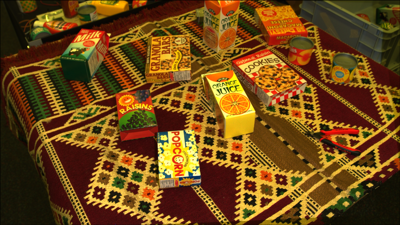

In [28]:
demo_sample = next(iter(query_dataloader))[0]

# show
print(f'{demo_sample=}')
print(f'{demo_sample["image"].size=}')
pilImageRow(demo_sample["image"], maxwidth=400)

#### 2. Proposal stage
returns a `src.utils.detection_utils.Detections` object

In [29]:
proposals = model.proposal_fwd_pass(demo_sample['image'])

proposals

It stores `boxes` and `masks`:

In [30]:
proposals.boxes.shape, proposals.masks.shape

(torch.Size([29, 4]), torch.Size([29, 1080, 1920]))

#### 3. DINO descriptor extraction for proposals

In [31]:
proposal_descriptors = model.dino_fwd_pass(demo_sample['image'], proposals)

proposal_descriptors.shape

torch.Size([29, 1024])

#### 4. Classification through matching proposals <-> templates

In [32]:
score_per_proposal, assigned_idx_object = model.classify(proposal_descriptors)

In [33]:
score_per_proposal, assigned_idx_object

(tensor([0.7994, 0.8653, 0.7738, 0.8846, 0.8849, 0.8202, 0.7332, 0.2215, 0.8407, 0.8857, 0.5699, 0.8207, 0.4891, 0.7664, 0.7886, 0.7503, 0.6522, 0.5747, 0.6332, 0.6052, 0.5933, 0.4842, 0.4130, 0.7992, 0.5673, 0.3076, 0.5142, 0.4728, 0.6984], device='cuda:0'),
 tensor([13, 22,  8, 16, 16, 21, 11,  9,  5, 16,  9, 20, 13, 18, 20, 18,  1,  9, 15,  1, 10,  9,  5,  5,  5,  2, 16,  9, 22], device='cuda:0'))

In [39]:
#!pip install git+https://github.com/facebookresearch/detectron2  # run this if you have not yet installed detectron2
from src.utils.visualization_detectron2 import CNOSVisualizer
import numpy as np
from PIL import Image

def show_results(top_n=16):
    visualizer = CNOSVisualizer(cfg.data.datasets[cfg.dataset_name].obj_names, img_size=np.array(demo_sample['image']).shape[:2])
    visualizer.forward(rgb=np.array(demo_sample['image'].convert('L').convert('RGB')), 
                       masks=proposals.masks.cpu().numpy()[:top_n], 
                       bboxes=proposals.boxes.cpu().numpy()[:top_n], 
                       scores=score_per_proposal[:top_n], 
                       labels=assigned_idx_object[:top_n],
                       save_path='/tmp/demo_inference.png')
    display(Image.open('/tmp/demo_inference.png'))

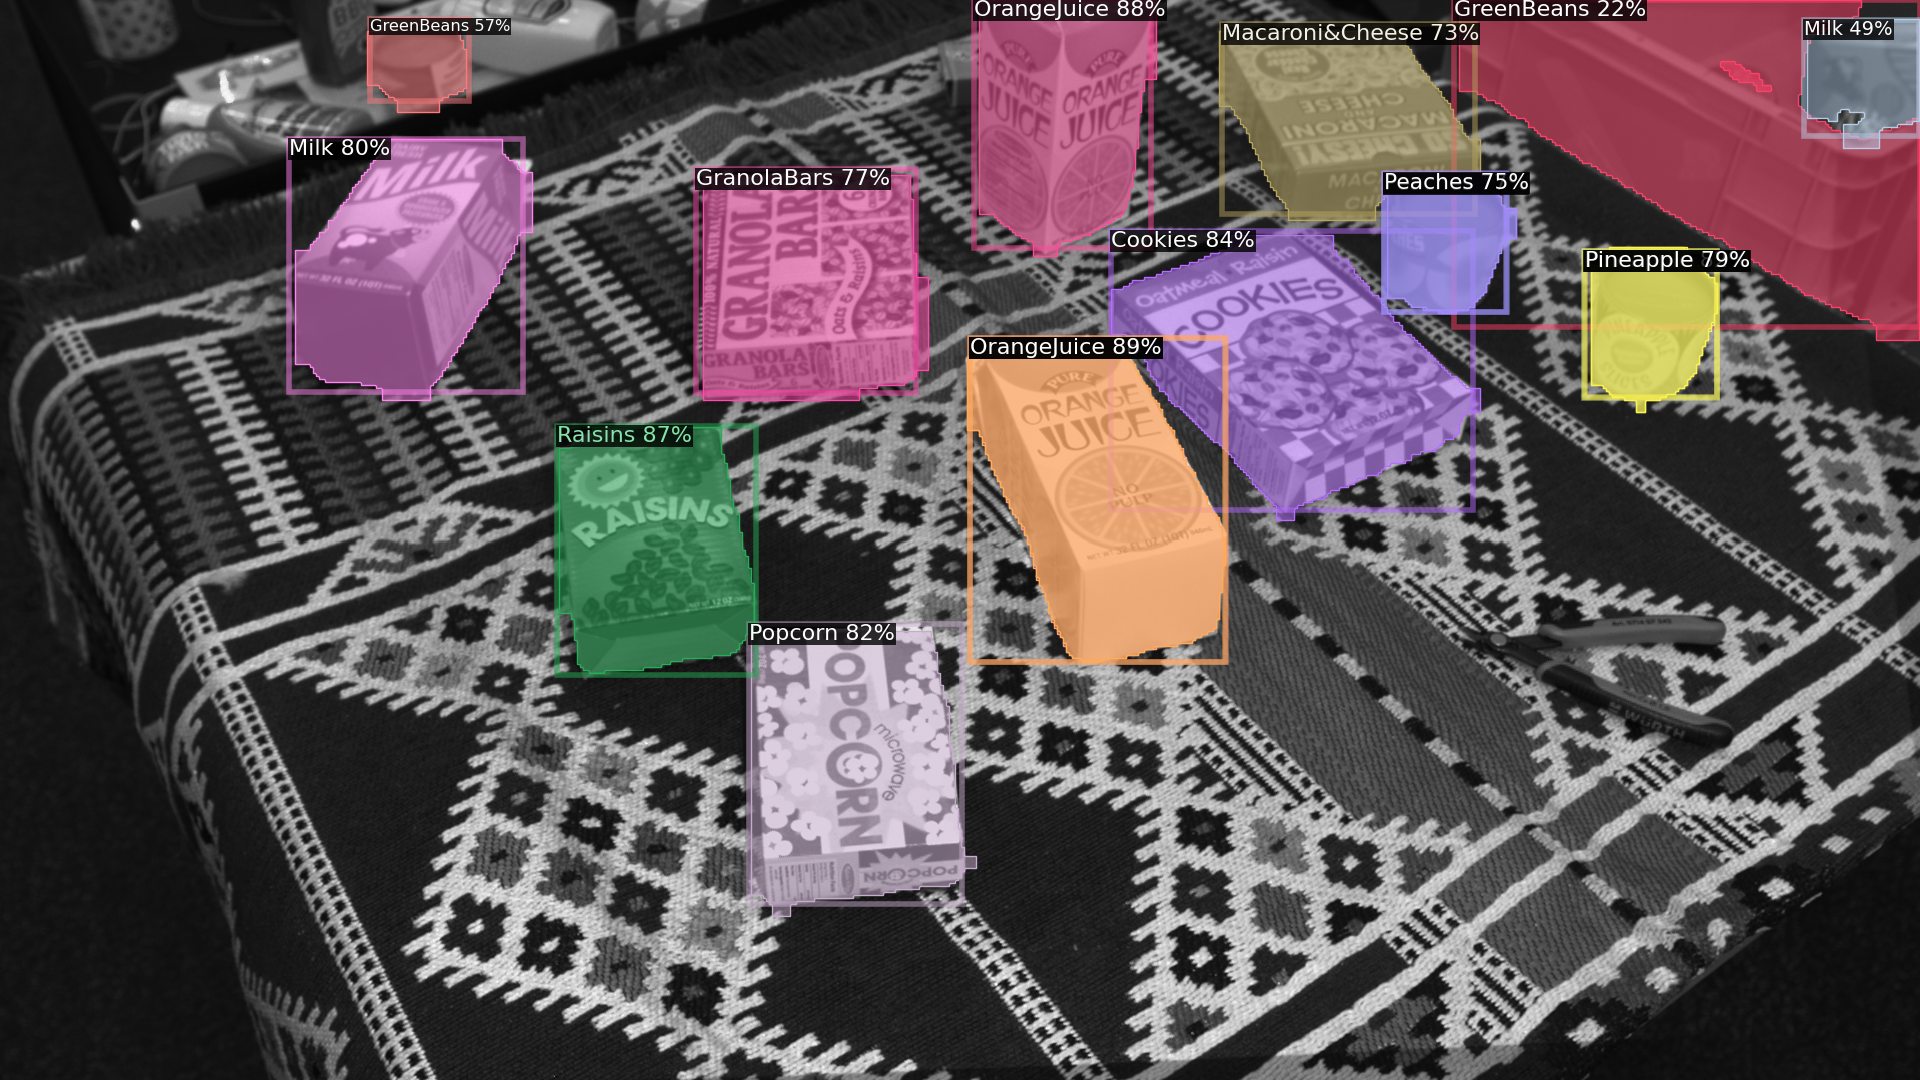

In [40]:
show_results()

### Done!